In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io as sio
import time
#import sima

In [2]:
def loadmat(filename):
    '''
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    
    from: `StackOverflow <http://stackoverflow.com/questions/7008608/scipy-io-loadmat-nested-structures-i-e-dictionaries>`_
    '''
    data = sio.loadmat(filename, struct_as_record=False, squeeze_me=True)
    return _check_keys(data)

def _check_keys(dict):
    '''
    checks if entries in dictionary are mat-objects. If yes
    todict is called to change them to nested dictionaries
    '''
    for key in dict:
        if isinstance(dict[key], sio.matlab.mio5_params.mat_struct):
            dict[key] = _todict(dict[key])
    return dict        

def _todict(matobj):
    '''
    A recursive function which constructs from matobjects nested dictionaries
    '''
    dict = {}
    for strg in matobj._fieldnames:
        elem = matobj.__dict__[strg]
        if isinstance(elem, sio.matlab.mio5_params.mat_struct):
            dict[strg] = _todict(elem)
        else:
            dict[strg] = elem
    return dict

def createBuckets2(true,deconvo, msWindow,hz):
    '''
    Difference to the one below:
    instead of specifying the number of buckets, we specify the window size in ms'''
    biggernum = max(deconvo.shape)
    smallernum = min(deconvo.shape)
    stepWidth = ((msWindow)/hz)
    bucketnum = (biggernum/stepWidth)
    deconvoBucket = np.zeros((smallernum,bucketnum))
    for i,col in enumerate(deconvo.T):
        for j in range(0,bucketnum):
            deconvoBucket[i,j] = sum(col[j*stepWidth:j*stepWidth+stepWidth]) 
    #for i in deconvoBucket:
    #    i[...] = map(float,(i/max(i)))

    biggernum = max(true.shape)
    smallernum = min(true.shape)
    stepWidth = (biggernum/stepWidth)
    
    trueBucket = np.zeros((smallernum,bucketnum))
    
    for i,col in enumerate(true.T):
        for j in range(0,bucketnum):
            trueBucket[i,j] = sum(col[j*stepWidth:j*stepWidth+stepWidth])
    #for i in trueBucket:
    #    i[...] = map(float,(i / max(i)))

    return(np.nan_to_num(trueBucket),np.nan_to_num(deconvoBucket))
    
def createBuckets (cai1result,cai1deconvo,bucketNumber):
    
    '''
    take: actual spike train, deconvolved spike train, number of buckets 
    return: n x bucketsize matrix containing firing rates in buckets, relative to the max value per trace
    '''
    biggernum = max(cai1result.shape)
    smallernum = min(cai1result.shape)
    stepWidth = (biggernum)/bucketNumber
    caiResultBucket = np.zeros((smallernum,bucketNumber))
    for i,col in enumerate(cai1result.T):
        for j in range(0,bucketNumber):
            caiResultBucket[i,j] = sum(col[j*stepWidth:j*stepWidth+stepWidth]) 
    for i in caiResultBucket:
        i[...] = map(float,(i/max(i)))

    biggernum = max(cai1deconvo.shape)
    smallernum = min(cai1deconvo.shape)
    stepWidth = biggernum/bucketNumber
    
    caiDeconvoBucket = np.zeros((smallernum,bucketNumber))
    
    for i,col in enumerate(cai1deconvo.T):
        for j in range(0,bucketNumber):
            caiDeconvoBucket[i,j] = sum(col[j*stepWidth:j*stepWidth+stepWidth])
    for i in caiDeconvoBucket:
        i[...] = map(float,(i / max(i)))

    return(np.nan_to_num(caiResultBucket),np.nan_to_num(caiDeconvoBucket))

def _loadGiniFile(fileList,path):
    apReturn = []
    valueList = []
    for cell in (fileList):
        apCollumn = _todict(loadmat(path+cell.strip())['obj']['timeSeriesArrayHash']['value'][4])['valueMatrix']
        valueCollumn = _todict(loadmat(path+cell.strip())['obj']['timeSeriesArrayHash']['value'][0])['valueMatrix']
        valueList.append(valueCollumn)
        stepwidth = len(apCollumn)/len(valueCollumn)
        apList = []
        
        for pos in range(len(valueCollumn)):
            thisStep = apCollumn[pos*stepwidth:pos*stepwidth+stepwidth]
            #thisStep = thisStep[~np.isnan(thisStep)]
            apList.append(sum(thisStep))
        apReturn.append(apList)
    caiFrame = pd.DataFrame(data=apReturn,index=range(len(apReturn)))
    valueFrame = pd.DataFrame(data=valueList,index=range(len(valueList)))
    return(valueFrame,caiFrame)

def rankByIndex(inputList):
    # return list of same length as input, ordered after size - biggest first, smallest last
    returnList = []
    inputList2 = list(inputList)
    for i in range(len(inputList2)):
        highPos = np.argmax(inputList2)
        returnList.append(highPos)
        inputList2[highPos] = 0
    return(returnList)

def _correlation(cell):
    correlations = []
    for i in range(len(cell[0])): #list1 and 2: list of lists of spike rates
        correlations.append(np.corrcoef(cell[0][i],cell[1][i])[0][1])
    return correlations

Below: stuff to read the .mat files from akerboom and chen and put them in sub-files containing only AP
or fluorescence data

In [214]:
fileString5 = "data_20120502_cell1_001.mat  data_20120502_cell4_002.mat  data_20120521_cell2_002.mat  data_20120521_cell4_003.mat  data_20120521_cell5_006.mat  data_20120502_cell1_002.mat  data_20120502_cell4_003.mat  data_20120521_cell2_003.mat  data_20120521_cell4_004.mat  data_20120521_cell5_007.mat  data_20120502_cell1_004.mat  data_20120510_cell1_001.mat  data_20120521_cell3_001.mat  data_20120521_cell4_005.mat  data_20120521_cell7_001.mat  data_20120502_cell1_005.mat  data_20120510_cell1_002.mat  data_20120521_cell3_002.mat  data_20120521_cell4_006.mat  data_20120521_cell7_002.mat  data_20120502_cell3_001.mat  data_20120521_cell10_002.mat  data_20120521_cell3_003.mat  data_20120521_cell4_007.mat  data_20120521_cell7_003.mat  data_20120502_cell3_002.mat  data_20120521_cell10_003.mat  data_20120521_cell3_004.mat  data_20120521_cell5_003.mat  data_20120502_cell3_003.mat  data_20120521_cell10_004.mat  data_20120521_cell3_005.mat  data_20120521_cell5_004.mat  data_20120502_cell4_001.mat  data_20120521_cell1_001.mat  data_20120521_cell4_002.mat  data_20120521_cell5_005.mat".split("  ")
path = "/home/maximilian/unistuff/paris_ens/cal_neuroim/testData/cai-1/GCaMP6f_11cells_Chen2013/"

#amItooSmart = _loadGiniFile(fileString5,path)
amItooSmart[1].to_csv("/home/maximilian/unistuff/paris_ens/cal_neuroim/testData/cai-1/11ChenAPs",sep=" ",float_format='%i')

Below: stuff to read AP trains and deconvoluted ap trains and do some analyses on them

Below: kicking difficult (read as: borderline ridiculous) data

In [41]:
outFileList = ["/home/maximilian/unistuff/paris_ens/cal_neuroim/testData/output/9chenDeconvo",
               "/home/maximilian/unistuff/paris_ens/cal_neuroim/testData/output/11chenDeconvo",
               "/home/maximilian/unistuff/paris_ens/cal_neuroim/testData/output/akerboomDeconvo",
               "/home/maximilian/unistuff/paris_ens/cal_neuroim/testData/output/campDeconvo",
               "/home/maximilian/unistuff/paris_ens/cal_neuroim/testData/output/gecoDeconvo",]

chen9Ap = pd.read_csv("/home/maximilian/unistuff/paris_ens/cal_neuroim/testData/cai-1/9ChenAPs",sep=" ").fillna(0).astype(int).as_matrix().transpose()
#chen9Deconvo = pd.read_csv("/home/maximilian/unistuff/paris_ens/cal_neuroim/testData/output/9chenDeconvo",sep=" ").fillna(0).astype(int).as_matrix()
chen9Deconvo = pd.read_csv(outFileList[0],sep=" ").fillna(0).astype(int).as_matrix()

chen11Ap = pd.read_csv("/home/maximilian/unistuff/paris_ens/cal_neuroim/testData/cai-1/11ChenAPs",sep=" ").fillna(0).astype(int).as_matrix().transpose()
#chen11Deconvo = pd.read_csv("/home/maximilian/unistuff/paris_ens/cal_neuroim/testData/output/11chenDeconvo",sep=" ").fillna(0).astype(int).as_matrix()
chen11Deconvo = pd.read_csv(outFileList[1],sep=" ").fillna(0).astype(int).as_matrix()

akerboomAp = pd.read_csv("/home/maximilian/unistuff/paris_ens/cal_neuroim/testData/cai-1/akerboomAPs",sep=" ").fillna(0).astype(int).as_matrix()
#akerboomDeconvo = pd.read_csv("/home/maximilian/unistuff/paris_ens/cal_neuroim/testData/output/akerboomDeconvo",sep=" ").fillna(0).astype(int).as_matrix()
akerboomDeconvo = pd.read_csv(outFileList[2],sep=" ").fillna(0).astype(int).as_matrix()

campAp =  pd.read_csv("/home/maximilian/unistuff/paris_ens/cal_neuroim/testData/cai-2/cai2_CAMP_full_aps.csv",sep=" ").fillna(0).astype(int).as_matrix().transpose()
#campDeconvo = pd.read_csv("/home/maximilian/unistuff/paris_ens/cal_neuroim/testData/output/campDeconvo",sep=" ").fillna(0).astype(int).as_matrix()
campDeconvo = pd.read_csv(outFileList[3],sep=" ").fillna(0).astype(int).as_matrix()

gecoAp=  pd.read_csv("/home/maximilian/unistuff/paris_ens/cal_neuroim/testData/cai-2/cai2_GECO_full_aps.csv",sep=" ").fillna(0).astype(int).as_matrix().transpose()
#gecoDeconvo = pd.read_csv("/home/maximilian/unistuff/paris_ens/cal_neuroim/testData/output/gecoDeconvo",sep=" ").fillna(0).astype(int).as_matrix()
gecoDeconvo = pd.read_csv(outFileList[4],sep=" ").fillna(0).astype(int).as_matrix()

chen9Ap= np.delete(chen9Ap,0,1)
chen9Ap = np.delete(chen9Ap,[14399,14400],0)
chen9Deconvo = np.delete(chen9Deconvo,0,1)

chenDelete = [17,16,15,12]
chen11Ap = np.delete(chen11Ap,chenDelete,1)
chen11Ap = np.delete(chen11Ap,[14399,14400],0)
chen11Deconvo= np.delete(chen11Deconvo,chenDelete,1)

campDelete= [18,17,7,4,3,2]
campDelete2 = [4805-i for i in range(1,7)]
campAp = np.delete(campAp,campDelete,1)
campDeconvo = np.delete(campDeconvo,campDelete,1)
campAp = np.delete(campAp,campDelete2,0)

gecoDelete = [8,5,3]
gecoDelete2 = [9610-i for i in range(1,12)]
gecoAp = np.delete(gecoAp,gecoDelete,1)
gecoAp = np.delete(gecoAp,gecoDelete2,0)
gecoDeconvo = np.delete(gecoDeconvo,gecoDelete,1)

In [42]:
akerboomBucket=createBuckets(akerboomAp,akerboomDeconvo,411)

bucket = 1000
campBucket=createBuckets(campAp,campDeconvo,bucket)
gecoBucket=createBuckets(gecoAp,gecoDeconvo,bucket)
chen9bucket = createBuckets(chen9Ap,chen9Deconvo,bucket)
chen11bucket = createBuckets(chen11Ap,chen11Deconvo,bucket)

print "chen9: " , np.mean(_correlation(chen9bucket))
print "chen11: " , np.mean(_correlation(chen11bucket))
print "akerboom: " , np.mean(_correlation(akerboomBucket))
print "camp: " , np.mean(_correlation(campBucket))
print "geco: " , np.mean(_correlation(gecoBucket))

chen9:  0.150725503085
chen11:  0.0895626166582
akerboom:  0.45167133686
camp:  0.135840265802
geco:  0.192853950632


In [9]:
for i in range(40,500,20):
    gecoBucket=createBuckets(gecoAp,gecoDeconvo,i)
    campBucket=createBuckets(campAp,campDeconvo,i)
    gecoCorrList.append(np.mean(_correlation(gecoBucket)))
    campCorrList.append(np.mean(_correlation(campBucket)))
steps = 99
akerboomMatrix = np.zeros((9,len(range(100,1000,steps))))
counter = 0
for i in range(100,1000,steps):
    akerboomBucket = createBuckets(akerboomAp,akerboomDeconvo,i)
    akerboomMatrix[:,counter] = (_correlation(akerboomBucket))
    counter += 1

for num,i in enumerate(akerboomMatrix[:,]):
    if (num == 0 or num == 2):
        continue
    plt.plot(range(100,1000,steps),i)
    plt.xlabel('Number of bins total spread over the trace')
    plt.ylabel('Pearson correlation coefficient')
plt.show()

NameError: name 'gecoCorrList' is not defined

In [7]:
akerboomTest = createBuckets(akerboomAp,akerboomDeconvo,170)
print _correlation(akerboomBucket)

 [0.26404908236145702, 0.71511884819874216, 0.38927216901458167, 0.51597806613895247, 0.42539961643032614, 0.34087896473762086, 0.25985028736289928, 0.37595923131094294, 0.33007814153824444]


Reduce arrays to be binary and get their AUC scores

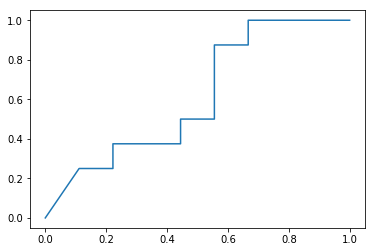

0.611111111111


In [52]:
from sklearn import metrics as met
testGecoTrue = map(lambda x: 1 if x >0 else 0,gecoBucket[1][:,0])
testGecoDec = gecoBucket[0][:,0]
fpr, tpr, threshold = met.roc_curve(testGecoTrue,testGecoDec)
auc = met.auc(fpr,tpr)
plt.plot(fpr,tpr)
plt.show()
print auc

In [190]:
bucketNumber = 411
cell1bucket = createBuckets(cell1ap,cell1deconvo,bucketNumber)
cell2bucket= createBuckets(cell2ap,cell2deconvo,bucketNumber)
cell3bucket = createBuckets(cell3ap,cell3deconvo,bucketNumber)
cell4bucket= createBuckets(cell4ap,cell4deconvo,bucketNumber)
cell5bucket = createBuckets(cell5ap,cell5deconvo,bucketNumber)
cell7bucket= createBuckets(cell7ap,cell7deconvo,bucketNumber)
cell10bucket = createBuckets(cell10ap,cell10deconvo,bucketNumber)

chen9bucket1 = createBuckets(chen9ap1,chen9deconvo1,bucketNumber)
chen9bucket2 = createBuckets(chen9ap2,chen9deconvo2,bucketNumber)
chen9bucket3 = createBuckets(chen9ap3,chen9deconvo3,bucketNumber)
chen9bucket4 = createBuckets(chen9ap4,chen9deconvo4,bucketNumber)

bucketNumber = 342
akerboom1bucket = createBuckets(akerboom1ap,akerboom1deconvo,bucketNumber)
akerboom2bucket = createBuckets(akerboom2ap,akerboom2deconvo,bucketNumber)
akerboom3bucket = createBuckets(akerboom3ap,akerboom3deconvo,bucketNumber)
akerboom4bucket = createBuckets(akerboom4ap,akerboom4deconvo,bucketNumber)

chen9correlations = [_correlation(chen9bucket1),_correlation(chen9bucket2),_correlation(chen9bucket3),_correlation(chen9bucket4)]
akerboomcorrelations = [_correlation(akerboom1bucket),_correlation(akerboom2bucket),_correlation(akerboom3bucket),_correlation(akerboom4bucket)]
chen11correlations= [_correlation(cell1bucket),_correlation(cell2bucket),_correlation(cell3bucket), _correlation(cell4bucket),_correlation(cell5bucket),_correlation(cell7bucket),_correlation(cell10bucket)]

chen11Score,chen9Score,akerboomScore = [],[],[]

for i in akerboomcorrelations:
    akerboomScore.append(np.mean(i))    
for i in chen9correlations:
    chen9Score.append(np.mean(i))
for i in chen11correlations:
    chen11Score.append(np.mean(i))
#print np.mean([np.mean(akerboomScore),np.mean(chen9Score),np.mean(chen11Score)])



0.052226702842
0.101591067354
0.206328032197
0.330757720494


In [4]:
trueList = [sum(i) for i in[cell1ap,cell2ap,cell3ap,cell4ap,cell5ap,cell7ap,cell10ap]]
decList = [sum(i) for i in [cell1deconvo,cell2deconvo,cell3deconvo,cell4deconvo,cell5deconvo,cell7deconvo,cell10deconvo]]
ratios = [np.true_divide(trueList[i],decList[i]) for i in range(len(trueList))]
meanRatios = []
for i in ratios:
    meanRatios.append(np.mean(i))
print meanRatios, np.mean(meanRatios)

trueListSum = []
decListSum = []

for i in range(7):
    trueListSum.append(sum(trueList[i]))
    decListSum.append(sum(decList[i]))

trueIndexList = rankByIndex(trueListSum)
decIndexList = rankByIndex(decListSum)
orderedTrueList = [trueListSum[i] for i in trueIndexList]
orderedDecList = [decListSum[i] for i in decIndexList]

print orderedTrueList
print trueIndexList
print '___________'
print orderedDecList
print decIndexList

[2.3915829881053261, 1.8680632630410656, 2.2735240865339685, 2.1935064315507149, 2.9948563899868246, 2.7600161276631865, 2.5530515975480848] 2.43351441206
[1229, 1074, 649, 517, 514, 316, 230]
[3, 0, 2, 4, 6, 5, 1]
___________
[586, 565, 250, 227, 181, 121, 120]
[3, 0, 2, 6, 4, 1, 5]


In [15]:
set1deconvo = pd.read_csv("/home/maximilian/unistuff/paris_ens/cal_neuroim/testData/deconvo1.csv",sep=' ').fillna(0).astype(int).as_matrix()
set2deconvo = pd.read_csv("/home/maximilian/unistuff/paris_ens/cal_neuroim/testData/deconvo2.csv",sep=' ').fillna(0).astype(int).as_matrix()
set4deconvo = pd.read_csv("/home/maximilian/unistuff/paris_ens/cal_neuroim/testData/deconvo4.csv",sep=' ').fillna(0).astype(int).as_matrix()
set5deconvo = pd.read_csv("/home/maximilian/unistuff/paris_ens/cal_neuroim/testData/deconvo10.csv",sep=' ').fillna(0).astype(int).as_matrix()
setHalfdeconvo = pd.read_csv('/home/maximilian/unistuff/paris_ens/cal_neuroim/testData/deconvoHalf.csv',sep=' ').fillna(0).astype(int).as_matrix()
set1ap = pd.read_csv("/home/maximilian/unistuff/paris_ens/cal_neuroim/simdata/aps1",sep=',').fillna(0).astype(int).as_matrix()
set2ap = pd.read_csv("/home/maximilian/unistuff/paris_ens/cal_neuroim/simdata/aps2",sep=',').fillna(0).astype(int).as_matrix()
set4ap = pd.read_csv("/home/maximilian/unistuff/paris_ens/cal_neuroim/simdata/aps4",sep=',').fillna(0).astype(int).as_matrix()
set5ap = pd.read_csv("/home/maximilian/unistuff/paris_ens/cal_neuroim/simdata/aps10",sep=',').fillna(0).astype(int).as_matrix()
setHalfap = pd.read_csv("/home/maximilian/unistuff/paris_ens/cal_neuroim/simdata/apsHalf",sep=',').fillna(0).astype(int).as_matrix()

In [168]:
deconvo50 = pd.read_csv("/home/maximilian/unistuff/paris_ens/cal_neuroim/simdata/foldChanges/deconvo1",sep=' ').fillna(0).astype(int).as_matrix()
deconvo55 = pd.read_csv("/home/maximilian/unistuff/paris_ens/cal_neuroim/simdata/foldChanges/deconvo2",sep=' ').fillna(0).astype(int).as_matrix()
deconvo60 = pd.read_csv("/home/maximilian/unistuff/paris_ens/cal_neuroim/simdata/foldChanges/deconvo3",sep=' ').fillna(0).astype(int).as_matrix()
deconvo65 = pd.read_csv("/home/maximilian/unistuff/paris_ens/cal_neuroim/simdata/foldChanges/deconvo4",sep=' ').fillna(0).astype(int).as_matrix()
deconvo70 = pd.read_csv("/home/maximilian/unistuff/paris_ens/cal_neuroim/simdata/foldChanges/deconvo5",sep=' ').fillna(0).astype(int).as_matrix()

In [170]:
decList = [np.sum(deconvo50),np.sum(deconvo55),np.sum(deconvo60),np.sum(deconvo65),np.sum(deconvo70),]
realList = np.multiply(apList2,20)
print rankByIndex(decList)
print rankByIndex(realList)

[1, 3, 2, 0, 4]
[4, 3, 2, 1, 0]


In [18]:
deconvoActivities = [np.sum(cell9deconvo),np.sum(cell11deconvo),np.sum(cai1deconvo),np.sum(campdeconvo),np.sum(gecodeconvo)]
realActivities = [np.sum(cell9ap),np.sum(cell11ap),np.sum(cai1result),np.sum(campaps),np.sum(gecoaps)]
#gecoaps = np.delete(gecoaps.T,[3,5,8,19],axis=0).T
cell9activities = sum(gecodeconvo)
cell9real = sum(gecoaps)

print cell9activities
print rankByIndex(cell9activities)
print cell9real
print rankByIndex(cell9real)

[ 54  23  72 138  55  67  63  76  26  37  61  64  37  95  37  48  51  22
  47  25]
[3, 13, 7, 2, 5, 11, 6, 10, 4, 0, 16, 15, 18, 9, 12, 14, 8, 19, 1, 17]
[  39  122  363 2362  412   31  402  707  304  118  457  292  178  351   95
  278  374  164   78   37]
[3, 7, 10, 4, 6, 16, 2, 13, 8, 11, 15, 12, 17, 1, 9, 14, 18, 0, 19, 5]


In [19]:
plt.imshow(cai1Buckets[0], cmap='hot', interpolation='spline16')
plt.xlabel("AP sum over 600 frames")
plt.ylabel("Cell/ROI number")
plt.title("cai1_9cell12")
plt.savefig("cai1_9cell12true.png")
plt.close()
plt.imshow(cai1Buckets[1], cmap='hot', interpolation='spline16')
plt.ylabel("Cell/ROI number")
plt.xlabel("AP sum over ")
plt.savefig("cai1_9cell12deconvo.png")
plt.close()

print '________________________'
plt.imshow(campBuckets[0], cmap='hot', interpolation='spline16')
plt.xlabel("AP sum over 240 frames")
plt.ylabel("Cell/ROI number")
plt.title("cai2, camp")
plt.savefig("cai2_camptrue.png")
plt.close()
plt.imshow(campBuckets[1], cmap='hot', interpolation='spline16')
plt.savefig("cai2_campdeconvo.png")
plt.close()
print '________________________'
plt.imshow(gecoBuckets[0], cmap='hot', interpolation='spline16')
plt.xlabel("AP sum over 480 frames")
plt.title("cai2, geco")
plt.ylabel("Cell/ROI number")
plt.savefig("cai2_gecotrue.png")
plt.close()
plt.imshow(gecoBuckets[1], cmap='hot', interpolation='spline16')
plt.savefig("cai2_gecodeconvo.png")
plt.close()
print '________________________'
plt.imshow(cell9resultBucket, cmap='hot', interpolation='spline16')
plt.xlabel("AP sum over 480 frames")
plt.ylabel("Cell/ROI number")
plt.title("cell9, electrode vs. deconvo")
plt.savefig("cai1_9cell13true.png")
plt.close()
plt.imshow(cell9deconvoBucket, cmap='hot', interpolation='spline16')
plt.savefig("cai1_9cell13deconvo.png")
plt.close()

print '________________________'
plt.imshow(cell11resultBucket, cmap='hot', interpolation='spline16')
plt.xlabel("AP sum over 480 frames")
plt.ylabel("Cell/ROI number")
plt.title("cell11, electrode vs. deconvo")
plt.savefig("cai1_11cell13true.png")
plt.close()
plt.imshow(cell11deconvoBucket, cmap='hot', interpolation='spline16')
plt.savefig("cai1_11cell13deconvo.png")
plt.close()


________________________
________________________
________________________
________________________


In [126]:
#code used for creation of set1 of simulated data

def alphaKernel (t, A,t_A,t_B):
    return np.float64(A*(np.exp(-t/t_A)-np.exp(-t/t_B)))


simFiles = ['/home/maximilian/unistuff/paris_ens/cal_neuroim/simdata/foldChanges/facHalf',
            '/home/maximilian/unistuff/paris_ens/cal_neuroim/simdata/foldChanges/fac1',
           '/home/maximilian/unistuff/paris_ens/cal_neuroim/simdata/foldChanges/fac1.5',
            '/home/maximilian/unistuff/paris_ens/cal_neuroim/simdata/foldChanges/fac2',
           '/home/maximilian/unistuff/paris_ens/cal_neuroim/simdata/foldChanges/fac2.5']
apList2 = [150,180,210,240,270]

for x in range(len(simFiles)):
    xMatrix = np.ndarray(shape=(100000,9),dtype='float32')
    apMatrix = np.zeros(shape=(100000,9),dtype='int')
    apList = []
    pos = -1
    for i in np.nditer(xMatrix,order='F',flags=['external_loop'],op_flags=['writeonly']):
        pos += 1
        localAPlist = []
        xtest = np.repeat(400,100000.)
        xnoise = 80. * np.random.normal(size = xtest.size)
        #xDrift = np.concatenate((np.arange(2000,0,-1),np.repeat(0,3000)))
        xtest = xtest +xnoise
        #apNumber = int(np.random.normal(loc=4,scale = 2)*0.5*i)
        apNumber = apList2[x]
        for j in range(apNumber):
            xdata = np.arange(0,int(400*np.random.normal(loc=1,scale=0.3)),1.)
            y = (alphaKernel(xdata,np.random.normal(loc=5,scale=0.3) * 400,
                            30* np.random.normal(loc=4,scale=1),10*np.random.normal(loc=4,scale=1)))
            APposition = int(np.random.sample(size=1)* 99000)
            apMatrix[APposition][pos] += 1
            APend = APposition + y.size 
            if(APend > xtest.size):
                y.resize(xtest.size-APposition)
            xtest[APposition:APend] = xtest[APposition:APend] + y
            if (APend < 99000 and xtest[APend] - xtest[APend+1] > 80 ):
                corrector = np.arange(xtest[APend] - xtest[APend+1],0,-10)
                if(APend+ corrector.size > xtest.size):
                    corrector.resize(xtest.size-APend)
                xtest[APend:APend+corrector.size] = xtest[APend:APend+corrector.size] + corrector
        i[...] = xtest
        apList.append(sorted(localAPlist))

    np.savetxt(simFiles[x],xMatrix,delimiter=',',fmt='%4.6f')

    #np.savetxt('/home/maximilian/unistuff/paris_ens/cal_neuroim/simdata/apsHalf',apMatrix,delimiter=',',fmt='%1.f')

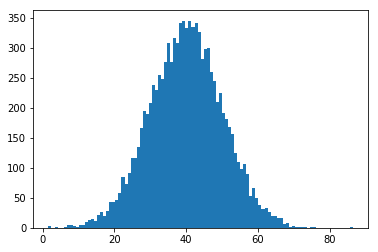

40.0203020717 10.0975278192


In [21]:
import matplotlib.pyplot as plt
test = np.zeros(10000)
for i in range(10000):
    test[i] = 10*np.random.normal(loc=4,scale=1)
plt.hist(test,bins=100)
plt.show()
print np.mean(test), np.std(test)

In [164]:
testrange = range(20)
for i,val in enumerate(testrange):
    testrange[i] += 
print testrange

[0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38]


[1835.7959987054762, 2231.5499289338036, 2016.5688714369714, 1844.6903180244822, 2248.072070418118] [77.49949957132353, 113.24314477317957, 144.74707480478946, 102.13289336427091, 147.8347101632229] [54.98610979846562, 34.982240911390775, 53.89255332087763, 23.90595014254043, 41.40430022612339]


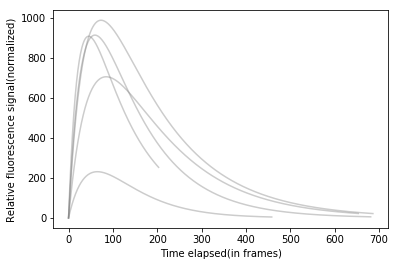

In [43]:
set1,set2,set3 = list(),list(),list()
for i in range(5):
    xdata = np.arange(0,int(500*np.random.normal(loc=1,scale=0.3)),1.)
    set1.append(400*np.random.normal(loc=5,scale=0.3))
    set2.append(30* np.random.normal(loc=4,scale=1))
    set3.append(10*np.random.normal(loc=4,scale=1))
    y = (alphaKernel(xdata,set1[i],set2[i],set3[i]))
    plt.plot(y,'grey',alpha=0.4)
plt.xlabel("Time elapsed(in frames)")
plt.ylabel("Relative fluorescence signal(normalized)")
plt.savefig('alphakernel')
print set1,set2,set3